## Testing the performance of VOPy
This notebook contains a comparison of VOPy implementations and of naive implementations of confidence region operation that checks domination and Pareto set calculation.

In [1]:
import time

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from vopy.utils import (
    set_seed,
    hyperrectangle_get_vertices,
    hyperrectangle_get_region_matrix,
)
from vopy.order import ConeTheta2DOrder
from vopy.confidence_region import (
    RectangularConfidenceRegion,
    confidence_region_check_dominates,
)

set_seed(0)

Create an `Order` object and visualize it's cone.

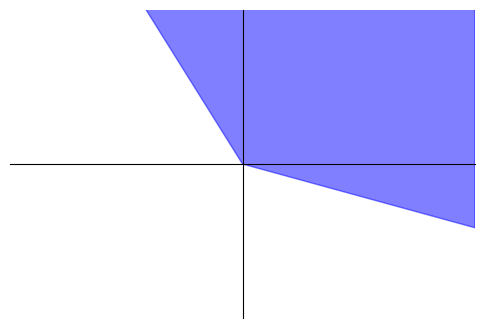

In [2]:
order = ConeTheta2DOrder(cone_degree=135)
fig_cone = order.ordering_cone.plot()

### Check dominates performance

Define utilities for generating random rectangles and visualizing them.

In [3]:
def order_vertices_clockwise(vertices):
    # Sort the vertices in clockwise order.
    center = np.mean(vertices, axis=0)
    angles = np.arctan2(vertices[:, 1] - center[1], vertices[:, 0] - center[0])
    return vertices[np.argsort(angles)]

def plot_rectangle(vertices, ax, label):
    len_vert = len(vertices)
    
    # Plot the points.
    ax.scatter(vertices[:, 0], vertices[:, 1], label=label)
    
    # Plot the edges of the rectangle by connecting the vertices.
    for i in range(len_vert):
        ax.plot(vertices[[i, (i+1)%len_vert], 0], vertices[[i, (i+1)%len_vert], 1], 'k-')

def visualize_comparison(rect1, rect2):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Plot each polytope with a different label
    rects = [rect1, rect2]
    labels = [r"$x$", r"$x'$"]
    for rect, label in zip(rects, labels):
        vertices = hyperrectangle_get_vertices(rect.lower, rect.upper)
        vertices = order_vertices_clockwise(vertices)  # Order the vertices in clockwise order.
        plot_rectangle(vertices, ax, label)

    ax.set_xlabel(r'$y_1$ Axis')
    ax.set_ylabel(r'$y_2$ Axis')
    plt.legend()
    plt.show()

def generate_rectangle():
    dim = 2
    center = 3 * np.random.randn(dim)
    size = 4 * np.random.rand(dim) + 1e-2
    lower = center - size
    upper = center + size
    return RectangularConfidenceRegion(dim, lower, upper)

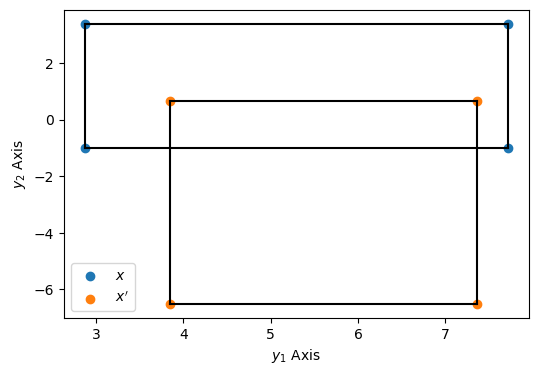

In [4]:
x = generate_rectangle()
x_prime = generate_rectangle()

visualize_comparison(x, x_prime)

Define the check dominates function to check if rect1 dominates rect2, using the definition in [Korkmaz et al. 2024](https://arxiv.org/abs/2412.02484) to formulate convex optimization problem.

In [5]:
def check_dominates_naive(order, rect1, rect2, slackness=0):
    vertices = hyperrectangle_get_vertices(rect1.lower, rect1.upper)
    obj2_matrix, obj2_boundary = hyperrectangle_get_region_matrix(rect2.lower, rect2.upper)

    m = order.ordering_cone.W.shape[1]

    for vertex in vertices:
        x = cp.Variable(m)
        y = cp.Variable(m)
        prob = cp.Problem(
            cp.Minimize(0),
            [
                x + y == vertex,
                obj2_matrix @ x >= obj2_boundary,
                order.ordering_cone.W @ y >= 0,
            ],
        )
        try:
            prob.solve()
        except cp.error.SolverError:
            prob.solve(solver=cp.SCS)

        if prob.status == "infeasible":
            return False

    return True

In [6]:
iter_cnt = 5000
rects = [[generate_rectangle(), generate_rectangle()] for _ in range(iter_cnt)]

vopy_start = time.time()
for i, (x, x_prime) in enumerate(rects):
    confidence_region_check_dominates(order, x, x_prime)
vopy_time = time.time() - vopy_start

naive_start = time.time()
for i, (x, x_prime) in enumerate(rects):
    naive_result = check_dominates_naive(order, x, x_prime)
naive_time = time.time() - naive_start

print(f"VOPy time: {vopy_time}, Naive time: {naive_time}")

for i, (x, x_prime) in enumerate(rects):
    vopy_result = confidence_region_check_dominates(order, x, x_prime)
    naive_result = check_dominates_naive(order, x, x_prime)
    if vopy_result != naive_result:
        print(f"VOPy: {vopy_result}, Naive: {naive_result}")
        visualize_comparison(x, x_prime)
        break


VOPy time: 0.0898141860961914, Naive time: 17.23957848548889


### Pareto set calculation performance

Let's now look at the Pareto set calculation performance w.r.t. the cardinality of the domain. Naive implementation is already present in the `Order` class.

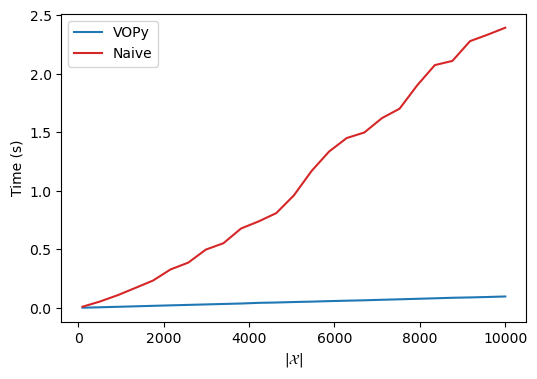

In [7]:
vopy_times = []
naive_times = []

pts_all = np.random.randn(10000, 2)
pt_cnts = np.linspace(100, 10000, 25, dtype=int)
for pt_cnt in pt_cnts:
    pts = pts_all[:pt_cnt]

    vopy_start = time.time()
    p_set_vopy = order.get_pareto_set(pts)
    vopy_time = time.time() - vopy_start

    naive_start = time.time()
    p_set_naive = order.get_pareto_set_naive(pts)
    naive_time = time.time() - naive_start

    vopy_times.append(vopy_time)
    naive_times.append(naive_time)

    assert set(sorted(p_set_vopy)) == set(sorted(p_set_naive))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(pt_cnts, vopy_times, c='tab:blue', label='VOPy')
ax.plot(pt_cnts, naive_times, c='tab:red', label='Naive')
ax.set_xlabel(r'$\vert \mathcal{X} \vert$')
ax.set_ylabel('Time (s)')
ax.legend()
plt.show()